# One-layer neural network model for softmax regression (multiclass classification)

[TODO]

In this notebook, we extend logistic regression to multiclass classification using [softmax regression](http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/#:~:text=Softmax%20regression%20(or%20multinomial%20logistic,kinds%20of%20hand%2Dwritten%20digits.) with.
neural network implementation with one single layer (**softmax layer**).
This is equivalent to a multinomial logistic regression model, only it is solved using neural networks (forward and backpropagation) rather than with maximum likelihood (or similar algorithms).

As example data, we again use Fisher's [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)

Basically, a neural network implementation of softmax regression looks like graph below.
There are as many units as classes in the multiclass classification problems (e.g. three classes in the *Iris* dataset: *Iris setos*, *Iris versicolor*, *Iris virginica*): each unit receives the vector of input features $\mathbf{x}$ and multiplies it by a vector of weights $\mathbf{w_u}$, specific to each unit $u$. The results are summed up together and the unit bias term $b_u$ is added. The real-valued $z_u$ variable is then activated with the *softmax* activation function to give the probability of belonging to the various classes of the problem.
In other words, each unit performs a specific and independent linear combination of the input variables, and the outputs the probability of belonging to one class: i.e., each unit models the probability of one class given the data (e.g. $P(y=\text{iris setosa}|x)$).

<img src="softmax_layer.png" alt="perceptron" style="height: 500px;"/>

## Loading libraries and setting the random seed

First of all, we load some necessary libraries; then we setup the random seed to ensure reproducibility of results. Since tensorflow uses an internal random generator we need to fix both the general seed (via numpy `seed()`) and tensorflow seed (via `set_seet()`)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

  # Set the seed using keras.utils.set_random_seed. This will set:
  # 1) `numpy` seed
  # 2) `tensorflow` random seed
  # 3) `python` random seed
tf.keras.utils.set_random_seed(10)

  # This will make TensorFlow ops as deterministic as possible, but it will
  # affect the overall performance, so it's not enabled by default.
  # `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

## Get the data

From `sklearn.datasets` we get a "bunch" object that contains both the `target` and the `features` (to be accessed as attributes): `<dataset>.target` and `<dataset>.data`.

In [11]:
import sklearn.datasets

## 1)
iris = sklearn.datasets.load_iris()
features = iris.data
target = iris.target

Next, we convert data and features (originally as `numpy` arrays) to `pandas` dataframes / series

In [12]:
iris.data = pd.DataFrame(features, columns=iris.feature_names) #converting numpy array -> pandas DataFrame
iris.target = pd.Series(target) #converting numpy array -> pandas Series

The **iris** dataset is a historic dataset first used by **Ronald Fisher** in his 1936 paper on linear discriminant analysis (LDA).
The dataset contains information on 150 flower samples, belonging to three species of Iris (Iris setosa, Iris virginica and Iris versicolor: the `target`).
Four `features` were measured from each sample: the length and the width of the sepals and of the petals, in centimeters.

## Exploratory Data Analysis (EDA)

As said, the feature data has 150 rown and 4 columns:

In [13]:
print('Shape of the feature table: ' + str(iris.data.shape))

Shape of the feature table: (150, 4)


Classes are represented via a numeric index: 0 for *setosa*, 1 for *versicolor*, 2 for *virginica*. The samples are in order: the first 50 samples are *setosa*, then 50 *versicolor* and the last 50 are *virginica*.

When working with a new dataset, it is always importat to plot the data. We are unfortunately talking about a 5-dimensional dataset (the four features + the target class) which is not easily representable.
One possibility is to take a slice (a subset) of the whole dataset.

In the next code chunk we plot two features plus the class.

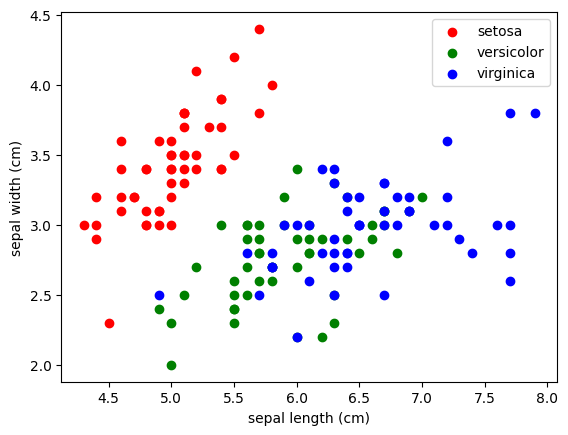

In [7]:
## SELECT FEATURES TO PLOT
#change these two values to plot different features, remembering the numbering:
# 0 : sepal length (cm)
# 1 : sepal width (cm)
# 2 : petal length (cm)
# 3 : petal width (cm)
feature_x = 0
feature_y = 1

#starting a new plot
fig, ax = plt.subplots()

#adding data in three bunches of 50, once per class
ax.scatter(x=iris.data.iloc[0:50,feature_x],    y=iris.data.iloc[0:50,feature_y],    c='red',   label=iris.target_names[0])
ax.scatter(x=iris.data.iloc[50:100,feature_x],  y=iris.data.iloc[50:100,feature_y],  c='green', label=iris.target_names[1])
ax.scatter(x=iris.data.iloc[100:150,feature_x], y=iris.data.iloc[100:150,feature_y], c='blue',  label=iris.target_names[2])

#the axis names are taken from feature names
ax.set_xlabel(iris.feature_names[feature_x])
ax.set_ylabel(iris.feature_names[feature_y])

#adding the legend and printing the plot
ax.legend()
plt.show()

This time, we are going to use all three classes as they are.

The problem is that our target array `iris.target` is a numeric array (e.g. [1 0 0 2 1 1 0 ...]).
However teose numbers (0, 1, and 2) do not represent real values. In other words, "virginica" is not twice "versicolor". Numbers here are used as labels, not as quantities.

As a matter of fact, to properly train a model the structure of the target array must be changed to [one-hot encoding](https://en.wikipedia.org/wiki/One-hot). In simple terms, it needs to become a table with one row per sample (150 in total) and one column per class (three in total). Something like:

| Setosa | Versicolor | Virginica |
|------|------|------|
|   0  |   1  |   0  |
|   1  |   0  |   0  |
|   1  |   0  |   0  |
|   0  |   0  |   1  |

As you can see the first sample is Versicolor, the second and third are Setosa, the last one is Virginica. Note that there is only a single "one" per row.

We need to do a little **preprocessing**.

## Data preprocessing

As said, we need to convert a numeric vector to a one-hot encoding (OHE) representation.
Luckily, it's easy to pass to one-hot encode using the keras function [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function):

To make the problem a little more challenging (and interesting) we decide to **drop half of the features**, **using only the first two** columns.

In [14]:
#the "utils" subpackage is very useful, take a look to it when you have time
from tensorflow.keras.utils import to_categorical

#converting to categorical
target_multi_cat = tf.keras.utils.to_categorical(target)

#since everything else is a Pandas dataframe, let's stick to the format
#for consistency
target_multi_cat = pd.DataFrame(target_multi_cat)

#let's take a look
print(target_multi_cat)

       0    1    2
0    1.0  0.0  0.0
1    1.0  0.0  0.0
2    1.0  0.0  0.0
3    1.0  0.0  0.0
4    1.0  0.0  0.0
..   ...  ...  ...
145  0.0  0.0  1.0
146  0.0  0.0  1.0
147  0.0  0.0  1.0
148  0.0  0.0  1.0
149  0.0  0.0  1.0

[150 rows x 3 columns]


We get the first two features, to make the example comparable with the previous notebook on binary classification

In [16]:
features = iris.data.iloc[:,0:2] ## we are selecting the first two features / columns

## Training and validation sets

Each time there is some kind of "learning" involved we need to split our data. A subset will be used for training, and a subset will be used for validation.

In our current dataset the samples are sorted by class: the first 100 are "non-virginica" and the remaining 50 are "virginica".
We want to keep this 2:1 proportion (roughly) the same in both train and validation set.

Obviously (given the ordered data), taking the first $80\%$ (120 samples) of the data as training and the rest (30 samples) as validation would be a bad choice ... (only 'virginica' samples in the validation set, 4:1 class proportion in the training set).   

Simple random sampling would also not be a good solution, since the 2:1 proportion will not be maintained.

Therefore we are going to use what is called a [stratified approach](https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/) using a [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) object from `scikit-learn`:


In [17]:
#we want to have the same proportion of classes in both train and validation sets
from sklearn.model_selection import StratifiedShuffleSplit

test_pct = 0.2

#building a StratifiedShuffleSplit object (sss among friends) with 20% data
#assigned to validation set (here called "test")
#random_state is used to control class balance between training and test sets (None to switch to random behavior)
sss = StratifiedShuffleSplit(n_splits=1, test_size= test_pct, random_state=0)

for train_index, val_index in sss.split(features, target_multi_cat):
    features_train = features.iloc[train_index, :]
    features_val   = features.iloc[val_index, :]
    target_train   = target_multi_cat.iloc[train_index, :]
    target_val     = target_multi_cat.iloc[val_index, :]

In [18]:
#shapes
print(features_train.shape)
print(features_val.shape)
print(target_train.shape)
print(target_val.shape)

#number of classes per split
print('\nClasses in train set:')
print(target_train.sum())
print('\nClasses in validation set:')
print(target_val.sum())

(120, 2)
(30, 2)
(120, 3)
(30, 3)

Classes in train set:
0    40.0
1    40.0
2    40.0
dtype: float32

Classes in validation set:
0    10.0
1    10.0
2    10.0
dtype: float32


We see that we have $80\%$ data ready for training and $20\%$ for validation, both sets with a 2:1 target class ratio: job done!

## Build the neural network model

We want to use a neural network model for logistic regression.
There are many `Python` frameworks that implement (Deep) Neural Networks: here we are using `Keras` (for more details on how to use *keras* a good starting point is the [documentation on training and evaluation](https://www.tensorflow.org/guide/keras/train_and_evaluate)).

Our neural network will be very minimal, as illustrated in the sketch at the beginning of this notebook: it will be comprised of only one node (neuron) that will perform both 1) the linear combination of weighted input variables + bias term; and 2) activate the result of step 1 with the sigmoid function to produce the probability of belonging to class "1" (or "0").

We are now ready to build the NN (neural network) model!

- model set-up
- model architecture and compiling

### Model set-up

We first need to define some hyperparameters:

1. activation function (`sigmoid`, this is a binary classification problem)
2. optimizer (the algorithm that carries out forward and backpropagation to solve the model)
3. the loss function (`binary cross-entropy`, again this is binary classification!)

In [ ]:
activation_function = 'sigmoid'
optimizing_method = 'rmsprop'
loss_function = 'binary_crossentropy'

### Model architecture

This is a one-layer one-unit neural network model.
The neural network is fully connected, meaning that the unit receives in input all features.

In [ ]:
#we are building a "sequential" model, meaning that the data will
#flow like INPUT -> ELABORATION -> OUTPUT. In particular, we will
#not have any loops, i.e. our output will never be recycled as
#input for the first layer
from keras.models import Sequential

#a "dense" layer is a layer were all the data coming in are connected
#to all nodes (fully connected).
#In our case there is only one node in the layer, and
#it receives all the input features
from keras.layers import Dense

# 2-class logistic regression in Keras
model = Sequential()
model.add(Dense(units=1, activation='sigmoid', input_dim=features_train.shape[1]))

#the model is declared, but we still need to compile it to actually
#build all the data structures
model.compile(optimizer=optimizing_method, loss=loss_function)

With the `.summary()` method we can take a look inside the model:

In [ ]:
print(model.summary())

We see that there are three trainable parameters (the weights for the two input variables, W1, W2, plus the bias term 'B'), and a single node.
The output is a single number. Excellent.

## Training the neural network model

Now that the model has been built and compiled, we are ready to train it on the data.
Training is an iterative process that cycles many times through what are called `epochs`. Remeber: one epoch is one cycle of forward and backward propagation.

We'll start with only ten epochs, to get the gist of it (and we print out the standard output to monitor the process):

In [ ]:
history = model.fit(features_train, target_train, epochs=10, validation_data=(features_val, target_val))

We asked for ten epochs and the network did just that. At each iteration the network is trying really hard to minimize the ["loss"](https://keras.io/api/losses/). The specifics are defined by our choice of loss function (we selected `binary_crossentropy`). The basic idea is that the smaller the loss the better the fit.

Note that the network minimizes the loss on the training set and does not use the validation set during the learning process. It can however measure the loss on the validation set to give us an idea on how well it can generalize on new data.

It's handy at this point to define a function that takes in the `history` object returned by `.fit()` and plots it:

In [ ]:
#function to take a look at losses evolution
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
plot_loss_history(history, 'Logistic (10 epochs)')

The good news is that the loss just goes down, both in train and validation set. We can keep training - without recompiling, we just add new epochs to our network.

In [ ]:
#putting verbose to 0 to avoid filling the screen
history2 = model.fit(features_train, target_train, epochs=190,
                     validation_data=(features_val, target_val), verbose=0)

Let's see if (and by how much) we improved our training:

In [ ]:
#putting together the whole history
history.history['loss'] += history2.history['loss']
history.history['val_loss'] += history2.history['val_loss']

#and plotting again
plot_loss_history(history, 'Logistic (500 epochs)')

This is very informative: the loss keeps decreasing, meaning that the network keeps improving. However after a first phase of steep improvement the gain for each epoch slows down considerably (diminishing returns).

Additionally, we now see a clear difference between what happens in the training and in the validation sets. This means that, while the network keeps improving, its performance on new data is expected to be worse than that on the training data (as theoretically expected: training by the book!).

We can now ask ourselves: what happens if we keep training for a long time? We have prepared the code for 10000 epochs, but it takes a long time to run, and it's faster if we simply show the saved results (but you can try to run it putting the following flag to `True`):

In [ ]:
do_10000_epochs = False

In [ ]:
#what happens if we keep going for a (very) long time?
if (do_10000_epochs):
    #train for 10000 epochs, just to show how the model evolves
    history3 = model.fit(features_train, target_train, epochs=9500,
                         validation_data=(features_val, target_val), verbose=0)

    #putting together the whole history
    history.history['loss'] += history3.history['loss']
    history.history['val_loss'] += history3.history['val_loss']

    #and plotting again
    plot_loss_history(history, 'Logistic (10000 epochs)')

Our pre-recorded results look like this:

![regression_10000_epochs](regression_loss10000.png)

It appears that there is constant, slow improvement on the training set. Improvement on validation set is slower, and if we had the patience to go for a veeeery long time the orange curve would become completely flat.

## Model evaluation

Any model is only useful when it's used to predict new, unknown data. In fact the whole validation set was put apart and not really used for training for this specific reason.

There are several ways in which a neural network model (or any model for that matter!) can be evaluated.
Here we look at a few approaches:

- decision boundary
- error-rate / accuracy
- confusion matrix

### Decision Boundary

Based on the model fit, we can plot the decision boundary, i.e. a representation in the two-dimensional feature space of the criterion that the model is using to classify the data in the two classes (`virginica` and `non-virginica` flowers).
For this task we'll use the [mlxtend module](http://rasbt.github.io/mlxtend/), which unfortunately does not usually come with the standard installation. Let's add it!

In [ ]:
!pip install mlxtend ##execute shell command

In [ ]:
from mlxtend.plotting import plot_decision_regions

#we'll print the training set
plot_decision_regions(X = features_val.to_numpy(), y = target_val.to_numpy(), clf=model)
plt.title('Decision boundary for 0 (non virginica) vs 1 (virginica) flowers')
plt.xlabel(iris.feature_names[feature_x])
plt.ylabel(iris.feature_names[feature_y])
plt.show()

The colored areas (yellow, blue) represent the behaviour of the trained model; the blue squares and yellow triangles are the actual samples in the validation set.

The **decision boundary is linear**, as expected by logistic regression. This means that all samples in the pink area will be classified as 1 (virginica) and all points in the blue area be considered 0 (non virginica).

Note that relatively many virginica samples are in the blue area compared to the numer of non-virginica present in the pink area. Also note that, roughly speaking, the regressor assigned a wider area to non-virginica. This is a direct consequence of having an unbalanced dataset: two-thirds of the samples are non-virginica (blue squares) and one-third are virginica (red triangles). **The resulting regressor is polarised** towards the more numerous class.

### Error rate / accuracy

To calculate the accuracy of the trained neural network model for binary classification, we first need to get the predictions made on the validation set.
Luckily, it's very easy to apply a trained model to new data (the validation set) via the [predict() method](https://keras.io/api/models/model_training_apis/#predict-method).

We can thus get our prediction for the iris flowers (see below):

In [ ]:
predictions = model.predict(features_val)
print(predictions)

**What do these numbers (the predictions) represent?** If you remember, in logistic regression we are modelling $P(y=1|x)$ (in short, $p(x)$), the probability for a sample of belonging to class "1" given the data `x`.

If we use the **0.5 threshold** to assign samples to the two classes (a very natural choice), we will say that a sample belongs to class "0" (`non-virginica`) if $P(x) < 0.5$, or to class "1" (`virginica`) if $p(x) > 0.5$.

Then, we can compare the predicted and true classes in the validation set and count the errors (remember, this is supervised learning, we know the "answers"!).


In [ ]:
predicted_class = np.where(predictions > 0.5, "virginica", "non-virginica")
target_class = np.where(target_val == 1, "virginica", "non-virginica")
target_class = target_class.reshape(len(target_class),1)

results = target_class == predicted_class

We now count the number of errors and of correct predictions, and from these the error rate and the accuracy as simple ratios on the total number of predictions:

In [ ]:
errors = np.invert(results).sum()
correct_predictions = results.sum()
total_n_predictions = len(results)

print("Error rate:", round(errors/total_n_predictions, 3))
print("Accuracy:", round(correct_predictions/total_n_predictions, 3))

### Confusion matrix

Besides the overall error rate / accuracy, it is always a good idea to look at the errors in the two classes.
This is especially important when data are unbalanced. We can have a more comprehensive assessment of the performance of the classification model by looking at the **confusion matrix** (more details <a href="https://en.wikipedia.org/wiki/Confusion_matrix">here</a>).

In [ ]:
from sklearn.metrics import confusion_matrix

labels = ['non-virginica','virginica']
con_mat_df = confusion_matrix( y_true = target_class, y_pred = predicted_class, labels=labels) #true are rows, predicted are columns
pd.DataFrame(
    con_mat_df,
    index = ['true:'+x for x in labels],
    columns = ['pred:'+x for x in labels])

Along the diagonal of the confusion matrix we have the correct predictions, off the diagonal the errors.

We see that 7 virginica flowers have been wrongly predicted as non-virginica flowers, and 3 non-virginica flowers have been wrongly predicted as virginica flowers.

It is apparent that the unblancedness of the data has skewed predictions in favor of non-virginica flowers, the most common type of flowers in the data (twice as much).

We can express this "bias" by measuring the accuracy in the two classes:

- **True positive rate** (**TPR**): the proportion of correct predictions in the positive class (class `1`, here virginica) $\rightarrow$ TP/(TP+FN) = 3/(3+7) = 3/10 = 0.333
- **True negative rate** (**TNR**): the proportion of correct predictions in the negative class (class `0`, here non-virginica) $\rightarrow$ TN/(TN+FP) = 17/(17+3) = 17/20 = 0.85